In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import csv
import random
import copy

from pyimagesearch.siamese_network import *
from pyimagesearch import config
from pyimagesearch import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa

### Paths

In [2]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/home/alvaro/Vehicle-Model-Recognition


It should be /home/user/Vehicle-Model-Recognition

### Dataset parameters

In [3]:
total_classes = 150
elements_per_class = 100
training_split = 0.75
img_resolution = (224, 224)

### Training parameters

### Load images

In [4]:
os.chdir(ROOT_DIR + '/dataset')

In [5]:
car_names = os.listdir('./')
car_names.sort()

In [6]:
labels = random.sample(car_names, k = total_classes)
labels.sort()
print(labels)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012', 'Bentley Continental Flying Spur Sedan 2007', 'Bentley Continental GT Coupe 2007', 'Bentley Continental GT Coupe 2012', 'Bentley Continental Supersports Conv. Convertible 2012', 'Bugatti Veyron 16.4 Convertib

In [7]:
(trainX, trainY), (testX, testY), (trainX_bbox, testX_bbox) = utils.load_dataset(ROOT_DIR, labels, elements_per_class, img_resolution=img_resolution, crop=True)
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
testX = np.asarray(testX)
testY = np.asarray(testY)
trainX.shape

(9277, 224, 224, 3)

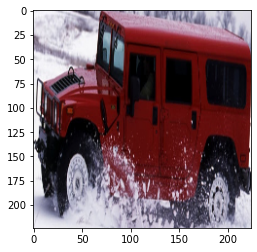

In [8]:
plt.imshow(trainX[0])

In [9]:
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
print(trainX.shape)
print(testX.shape)

(9277, 224, 224, 3, 1)
(3085, 224, 224, 3, 1)


In [10]:
norm_trainY = utils.normalize_labels(trainY)
norm_testY = utils.normalize_labels(testY)

In [11]:
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = utils.make_pairs(trainX, norm_trainY)
(pairTest, labelTest) = utils.make_pairs(testX, norm_testY)

[INFO] preparing positive and negative pairs...


In [12]:
pairTrain.shape

(18554, 2, 224, 224, 3, 1)

In [13]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=(img_resolution[0], img_resolution[1], 3))
imgB = Input(shape=(img_resolution[0], img_resolution[1], 3))
# featureExtractor = build_siamese_model((img_resolution[0], img_resolution[1], 1))
featureExtractor = build_vgg16((img_resolution[0], img_resolution[1], 3))
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
# distance = Lambda(utils.euclidean_distance)([featsA, featsB])
feats = Concatenate()([featsA, featsB])
feats = Dense(128, activation='relu')(feats)
distance = Dense(64, activation='relu')(feats)
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# compile the model
print("[INFO] compiling model...")
# model.compile(loss="binary_crossentropy", optimizer="adam",
# 	metrics=["accuracy"])
model.compile(loss=tfa.losses.ContrastiveLoss(), optimizer="adam",
	metrics=["accuracy"])

[INFO] building siamese network...
[INFO] compiling model...


In [14]:
checkpoint_callback = ModelCheckpoint("saved_models/best_model.hdf5",
                                      monitor='val_accuracy',verbose=1,
                                      save_best_only=True, mode='auto',
                                      period=1)

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG16_confA (Functional)        (None, 128)          129290752   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           VGG16_confA[0][0]     

In [16]:
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=4, 
	epochs=config.EPOCHS,
    callbacks=[checkpoint_callback])

[INFO] training model...
Epoch 1/100
  79/4639 [..............................] - ETA: 2:21:07 - loss: 0.5342 - accuracy: 0.5348

KeyboardInterrupt: 